In [1]:
"""
Example file which shows some simple curve fitting using DARTSRegressor and some other estimators.
"""

import logging
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

from autora.skl.darts import DARTSRegressor, ValueType

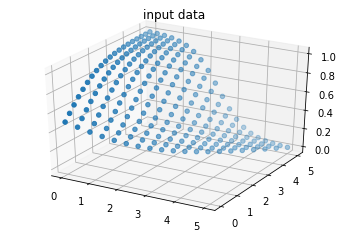

In [4]:

# %% Define some helper functions


def show_results_complete(
    data_: pd.DataFrame,
    estimator=None,
    show_results=True,
    projection="2d",
    label=None,
):
    """
    Function to plot input data (x_, y_) and the predictions of an estimator for the same x_.
    """
    if projection == "2d":
        plt.figure()
        data_.plot.scatter(
            "S1", "S2", c="difference_detected", cmap="viridis", zorder=10
        )
    elif projection == "3d":
        fig = plt.figure()
        ax = fig.add_subplot(projection="3d")
        ax.scatter(data_["S1"], data["S2"], data["difference_detected"])

        if estimator is not None:
            xs, ys = np.mgrid[0:5:0.2, 0:5:0.2]  # type: ignore

            zs = estimator.predict(np.column_stack((xs.ravel(), ys.ravel())))

            ax.plot_surface(xs, ys, zs.reshape(xs.shape), alpha=0.5)

    if label is not None:
        plt.title(label)

    if show_results:
        plt.show()

    return


# %% Load the data


data = pd.read_csv("./weber_data.csv")
show_results = partial(show_results_complete, data_=data, projection="3d")
show_results(label="input data")

X = data[["S1", "S2"]]
y = data["difference_detected"]


/Users/jholla10/Library/Caches/pypoetry/virtualenvs/autora-2PgcgopX-py3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


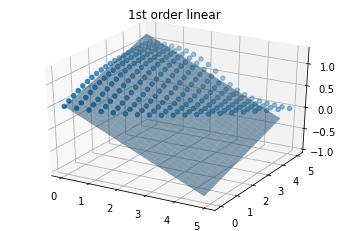

In [5]:

# %% Fit first using a super-simple linear regression

first_order_linear_estimator = LinearRegression()
first_order_linear_estimator.fit(X, y)

show_results(estimator=first_order_linear_estimator, label="1st order linear")

/Users/jholla10/Library/Caches/pypoetry/virtualenvs/autora-2PgcgopX-py3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


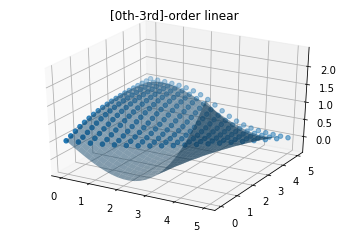

In [6]:

# %% Fit using a 0-3 order polynomial, getting the best fit for the data.
polynomial_estimator = GridSearchCV(
    make_pipeline(PolynomialFeatures(), LinearRegression(fit_intercept=False)),
    param_grid=dict(polynomialfeatures__degree=range(4)),
)
polynomial_estimator.fit(X, y)

show_results(estimator=polynomial_estimator, label="[0th-3rd]-order linear")

  0%|          | 0/30 [00:00<?, ?it/s]

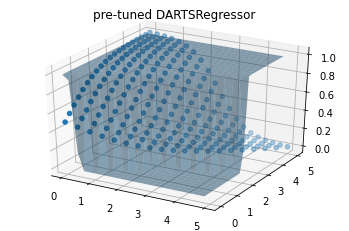

Edge (0): 2.7111 * x + -1.0925
Edge (1): -4.9780 * x
Edge (2): 2.7111 * x + -1.0925
Edge (3): -4.9780 * x
Edge (4): ReLU(2.7316 * x + 0.6631)
Classifier from Edge 0: x.*(-2.1126) .+(0.2463)
Classifier from Edge 1: x.*(-2.6919)
0 2
[('linear', 0), ('mult', 1), ('linear', 0), ('mult', 1), ('lin_relu', 2)] 0
[('linear', 0), ('mult', 1), ('linear', 0), ('mult', 1), ('lin_relu', 2)] 1
2 5
[('linear', 0), ('mult', 1), ('linear', 0), ('mult', 1), ('lin_relu', 2)] 2
[('linear', 0), ('mult', 1), ('linear', 0), ('mult', 1), ('lin_relu', 2)] 3
[('linear', 0), ('mult', 1), ('linear', 0), ('mult', 1), ('lin_relu', 2)] 4


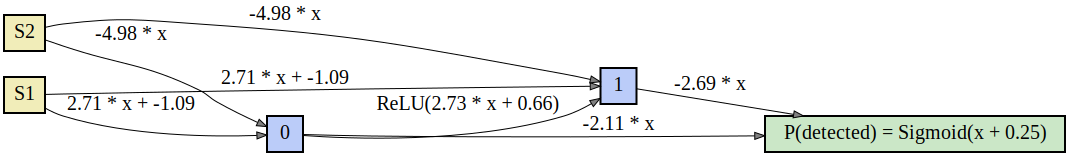

In [7]:
darts_estimator_tuned = DARTSRegressor(
    batch_size=64,
    arch_updates_per_epoch=1,
    param_updates_per_epoch=500,
    max_epochs=30,
    output_type=ValueType.PROBABILITY,
    num_graph_nodes=2,
)

darts_estimator_tuned.fit(X, y)

show_results(estimator=darts_estimator_tuned, label="pre-tuned DARTSRegressor")
darts_estimator_tuned.visualize_model()

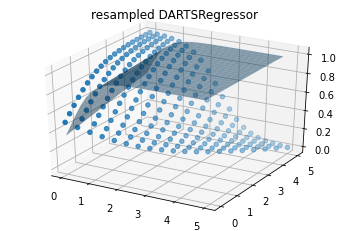

Edge (0): -4.8545 * x
Edge (1): logistic(-0.1687 * x + 0.0129)
Edge (2): 2.6417 * x + -1.0653
Edge (3): logistic(-0.1687 * x + 0.0129)
Edge (4): logistic(-0.1687 * x + 0.0129)
Classifier from Edge 0: x.*(-2.0634) .+(0.2409)
Classifier from Edge 1: x.*(-2.6291)
0 2
[('mult', 0), ('lin_sigmoid', 1), ('linear', 0), ('lin_sigmoid', 1), ('lin_sigmoid', 2)] 0
[('mult', 0), ('lin_sigmoid', 1), ('linear', 0), ('lin_sigmoid', 1), ('lin_sigmoid', 2)] 1
2 5
[('mult', 0), ('lin_sigmoid', 1), ('linear', 0), ('lin_sigmoid', 1), ('lin_sigmoid', 2)] 2
[('mult', 0), ('lin_sigmoid', 1), ('linear', 0), ('lin_sigmoid', 1), ('lin_sigmoid', 2)] 3
[('mult', 0), ('lin_sigmoid', 1), ('linear', 0), ('lin_sigmoid', 1), ('lin_sigmoid', 2)] 4


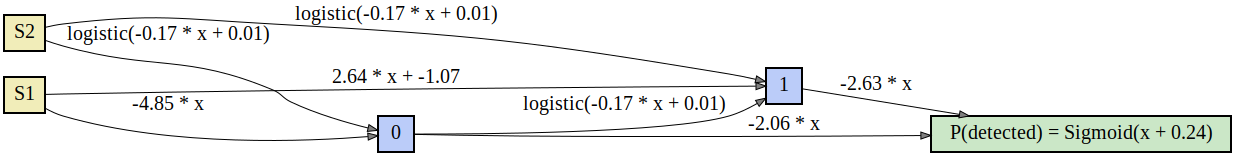

In [8]:
darts_estimator_tuned.resample_model(sampling_strategy="sample")
show_results(estimator=darts_estimator_tuned, label="resampled DARTSRegressor")
darts_estimator_tuned.visualize_model()
